### Setup

In [1]:
!pip install keras_preprocessing
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from os import listdir
from pickle import dump
from pickle import load
from numpy import argmax
from keras.applications.vgg16 import VGG16
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from keras_preprocessing.text import Tokenizer
from collections import Counter
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.layers import concatenate
from keras.utils import plot_model
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
import matplotlib.pyplot as plt
import json

from PIL import Image
import torch
from transformers import AutoProcessor, AutoModelForCausalLM

In [3]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load and prepare retrieval test dataset

In [4]:
dataset_prefix = '/content/drive/MyDrive/MVA/DL/fake_database/'
NUM_IMAGES = 50

images_filepaths = []
with open(dataset_prefix + 'captions.json', 'rb') as f:
    # Load MS-COCO annotations.
    mscoco_info = json.load(f)
    image_infos = list(mscoco_info['images'])
    
    # List all the images from our fake database.
    images_filepaths = [f for f in os.listdir(dataset_prefix + 'images/') if os.path.isfile(os.path.join(dataset_prefix + 'images/', f))]
    images_filepaths = images_filepaths[:NUM_IMAGES]

    # Collect the image ids.
    image_ids_2_filepath = {o['id']: o['file_name'] for o in image_infos if o['file_name'] in images_filepaths}

    # Truth captions = query captions.
    # By using one of the true captions as the query, we expect the image to be returned.
    queries_captions = []
    expected_retrieved_image_id = []
    ordered_images_filepaths = []

    valid_database_images_filepaths = []
    valid_database_images_ids = []

    for o in mscoco_info['annotations']:
        if o['image_id'] in image_ids_2_filepath.keys():
            queries_captions.append(o['caption'])
            expected_retrieved_image_id.append(o['image_id'])
            ordered_images_filepaths.append(dataset_prefix + 'images/' + image_ids_2_filepath[o['image_id']])

            # The image has been selected.
            if o['image_id'] not in valid_database_images_ids:
              valid_database_images_ids.append(o['image_id'])
              valid_database_images_filepaths.append(dataset_prefix + 'images/' + image_ids_2_filepath[o['image_id']])

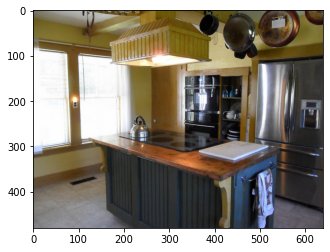

a kitchen with a center isle stove, and stainless steel refrigerator.
1355
/content/drive/MyDrive/MVA/DL/fake_database/images/COCO_train2014_000000001355.jpg



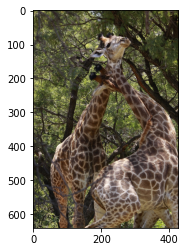

The two giraffes appear to be hugging each other.
72
/content/drive/MyDrive/MVA/DL/fake_database/images/COCO_train2014_000000000072.jpg


In [5]:
plt.imshow(Image.open(open(ordered_images_filepaths[0], 'rb')).convert('RGB'))
plt.show()
print(queries_captions[0])
print(expected_retrieved_image_id[0])
print(ordered_images_filepaths[0])
print()
plt.imshow(Image.open(open(ordered_images_filepaths[-1], 'rb')).convert('RGB'))
plt.show()
print(queries_captions[-1])
print(expected_retrieved_image_id[-1])
print(ordered_images_filepaths[-1])

### Define functions to caption the images in the retrieval test dataset with each method

In [6]:
def extract_feature(model, file_name):
    img = load_img(file_name, target_size=(224, 224)) #size is 224,224 by default
    x = img_to_array(img) #change to np array
    x = np.expand_dims(x, axis=0) #expand to include batch dim at the beginning
    x = preprocess_input(x) #make input confirm to VGG16 input format
    fc2_features = model.predict(x)
    return fc2_features

def generate_caption(pred_model, caption_train_tokenizer, photo, max_length):
    in_text = '<START>'
    caption_text = list()
    for i in range(max_length):
        # integer encode input sequence
        sequence = caption_train_tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        word_index = argmax(model_softMax_output)
        # map integer to word
        word = caption_train_tokenizer.index_word[word_index]
        #print(word)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word != 'end':
            caption_text.append(word)
        if word == 'end':
            break
    return caption_text

def flatten(lst):
    return sum( ([x] if not isinstance(x, list) else flatten(x) for x in lst), [] )

def generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length, vocab_size, beam_width):
    sequence = caption_train_tokenizer.texts_to_sequences(['<START>'])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    model_softMax_output = np.squeeze(pred_model.predict([photo,sequence], verbose=0))
    most_likely_seq=np.argsort(model_softMax_output)[-beam_width:]
    most_likely_prob=np.log(model_softMax_output[most_likely_seq])

    most_likely_cap = list()
    for j in range(beam_width):
        most_likely_cap.append(list())
        most_likely_cap[j] =[[caption_train_tokenizer.index_word[most_likely_seq[j]]]]

    for i in range(max_length):    
        temp_prob = np.zeros((beam_width, vocab_size))
        for j in range(beam_width):
            if most_likely_cap[j][-1] != ['end']: #if not terminated
                num_words = len(most_likely_cap[j])
                sequence = caption_train_tokenizer.texts_to_sequences(most_likely_cap[j])
                sequence = pad_sequences(np.transpose(sequence), maxlen=max_length)
                model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
                temp_prob[j,] = (1/(num_words)) *(most_likely_prob[j]*(num_words-1) + np.log(model_softMax_output)) #update most likily prob
            else:
                temp_prob[j,] = most_likely_prob[j] + np.zeros(vocab_size) - np.inf
                temp_prob[j,0] = most_likely_prob[j]

        x_idx, y_idx = np.unravel_index(temp_prob.flatten().argsort()[-beam_width:], temp_prob.shape)

        most_likely_cap_temp = list()
        for j in range(beam_width):
            most_likely_prob[j] = temp_prob[x_idx[j],y_idx[j]]
            most_likely_cap_temp.append(list())
            most_likely_cap_temp[j] = most_likely_cap[x_idx[j]].copy()
            if most_likely_cap_temp[j][-1] != ['end']:
                most_likely_cap_temp[j].append([caption_train_tokenizer.index_word[y_idx[j]]])

        most_likely_cap = most_likely_cap_temp.copy()

        finished = True
        for j in range(beam_width):
            if most_likely_cap_temp[j][-1] != ['end']:
                finished = False

        if finished == True:
            break

    final_caption = list()

    for j in range(beam_width):
        final_caption.append(' '.join(flatten(most_likely_cap[j][0:-1])))

    return final_caption, most_likely_prob

In [7]:
def caption_images_Baseline(images_filepaths, images_ids):
  # Load the model.
  caption_train_tokenizer_path = '/content/drive/MyDrive/MVA/DL/caption_train_tokenizer.pkl'
  model_path = '/content/drive/MyDrive/MVA/DL/modelConcat_1_5.h5'

  base_model = VGG16(include_top=True)
  feature_extract_pred_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
  caption_train_tokenizer = load(open(caption_train_tokenizer_path, 'rb'))
  max_length = 33
  vocab_size = 7506
  beam_width = 5

  pred_model = load_model(model_path) 

  # Extract all the features.
  print("[Baseline] Extracting all the features...")
  extracted_features = dict()
  for (fp, id) in zip(images_filepaths, images_ids):
    extracted_features[id] = extract_feature(feature_extract_pred_model, fp)

  # Compute the captions.
  print("[Baseline] Computing the captions...")
  captions_per_id = dict()

  for (fp, id) in zip(images_filepaths, images_ids):
    features = extracted_features[id]
    caption, prob = generate_caption_beam(pred_model, caption_train_tokenizer, features, max_length, vocab_size, beam_width)
    caption = ''.join(caption[np.argmax(prob)])
    captions_per_id[id] = [caption]

  return captions_per_id
  

In [8]:
def caption_images_GIT(images_filepaths, images_ids):
  # Load the model.
  processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
  model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)

  # Compute the captions.
  captions_per_id = dict()

  for (fp, id) in zip(images_filepaths, images_ids):
    with open(fp, 'rb') as image_file_handle:
      raw_image = Image.open(image_file_handle).convert('RGB')
      inputs = processor(images=raw_image, return_tensors="pt")
      pixel_values = inputs.pixel_values.to(device)
      generated_ids = model.generate(pixel_values=pixel_values, max_length=50)

      [captions] = processor.batch_decode(generated_ids, skip_special_tokens=True)
      captions_per_id[id] = [captions]

  return captions_per_id


### Compute the captions for all images with each model

In [9]:
baseline_captions = caption_images_Baseline(valid_database_images_filepaths, valid_database_images_ids)

[Baseline] Extracting all the features...
1/1 [==============================] - 0s 30ms/step
[Baseline] Computing the captions...


<ipython-input-6-5aa67ae58192>:59: RuntimeWarning: divide by zero encountered in log
  temp_prob[j,] = (1/(num_words)) *(most_likely_prob[j]*(num_words-1) + np.log(model_softMax_output)) #update most likily prob


In [10]:
git_captions = caption_images_GIT(valid_database_images_filepaths, valid_database_images_ids)

### Define the GloVe embedder

In [11]:
import string
import numpy as np
import torch
from torch import nn


def load_glove_vocabulary(filepath):
    vocab = []
    with open(filepath, "rt", encoding="utf8") as file:
        full_content = file.read().strip().split('\n')

    lookup_table = dict()
    vocab.append('<pad>')
    vocab.append('<unk>')

    i = 2
    for line in full_content:
        word = line.split(' ')[0]
        vocab.append(word)
        lookup_table[word] = i
        i += 1

    return np.array(vocab), lookup_table


# https://medium.com/mlearning-ai/load-pre-trained-glove-embeddings-in-torch-nn-embedding-layer-in-under-2-minutes-f5af8f57416a
def load_glove_weights(filepath):
    """ Loads the pre-trained GloVe weights. """
    vocab, embeddings = [], []
    with open(filepath, "rt", encoding="utf8") as file:
        full_content = file.read().strip().split('\n')

    lookup_table = dict()

    i = 2
    for line in full_content:
        word = line.split(' ')[0]
        vec = [float(val) for val in line.split(' ')[1:]]
        vocab.append(word)
        embeddings.append(vec)
        lookup_table[word] = i
        i += 1

    # Add the pad and unknown tokens.
    vocab.insert(0, '<pad>')
    vocab.insert(1, '<unk>')

    np_embeddings = np.asarray(embeddings)
    pad_emb = np.zeros((1, np_embeddings.shape[1]))
    unk_emb = np.mean(np_embeddings, axis=0, keepdims=True)

    np_embeddings = np.vstack((pad_emb, unk_emb, np_embeddings))
    return np.array(vocab), np_embeddings, lookup_table


def tokenizer_fn(input_str):
    # Lowercase
    # Remove all punctuation
    # Remove before/after whitespaces
    # Split on whitespaces
    return input_str.lower().translate(str.maketrans('', '', string.punctuation)).strip().split(' ')


class QueryEmbedder:
    """ Computes the embeddings for a query. """
    def __init__(self):
        self.tokenizer = tokenizer_fn
        self.glove_vocab, self.glove_embeddings, self.lookup_table = load_glove_weights("/content/drive/MyDrive/MVA/DL/glove.6B.50d.txt")

        self.glove_embeddings = torch.from_numpy(self.glove_embeddings).float()
        self.embedding_layer = nn.Embedding.from_pretrained(self.glove_embeddings)

        self.pad_token = self.glove_embeddings[0, :]
        self.unk_token = self.glove_embeddings[1, :]

    def encode(self, query_string):
        query_tokens = self.tokenizer(query_string)

        tokens_indices = []
        for token in query_tokens:
            if token in self.lookup_table:
                tokens_indices.append(self.lookup_table[token])
            else:
                # 1 is the index for the <unk> word/token.
                tokens_indices.append(1)

        tokens_indices = torch.from_numpy(np.asarray(tokens_indices)).long()
        return tokens_indices

    def embed(self, tokens_indices):
        return self.embedding_layer(tokens_indices)


In [47]:
# -*- coding: utf-8 -*-
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""ROUGe metric implementation.

This is a modified and slightly extended verison of
https://github.com/miso-belica/sumy/blob/dev/sumy/evaluation/rouge.py.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import itertools
import numpy as np

#pylint: disable=C0103


def _get_ngrams(n, text):
  """Calcualtes n-grams.

  Args:
    n: which n-grams to calculate
    text: An array of tokens

  Returns:
    A set of n-grams
  """
  ngram_set = set()
  text_length = len(text)
  max_index_ngram_start = text_length - n
  for i in range(max_index_ngram_start + 1):
    ngram_set.add(tuple(text[i:i + n]))
  return ngram_set


def _split_into_words(sentences):
  """Splits multiple sentences into words and flattens the result"""
  return list(itertools.chain(*[_.split(" ") for _ in sentences]))


def _get_word_ngrams(n, sentences):
  """Calculates word n-grams for multiple sentences.
  """
  assert len(sentences) > 0
  assert n > 0

  words = _split_into_words(sentences)
  return _get_ngrams(n, words)


def _len_lcs(x, y):
  """
  Returns the length of the Longest Common Subsequence between sequences x
  and y.
  Source: http://www.algorithmist.com/index.php/Longest_Common_Subsequence

  Args:
    x: sequence of words
    y: sequence of words

  Returns
    integer: Length of LCS between x and y
  """
  table = _lcs(x, y)
  n, m = len(x), len(y)
  return table[n, m]


def _lcs(x, y):
  """
  Computes the length of the longest common subsequence (lcs) between two
  strings. The implementation below uses a DP programming algorithm and runs
  in O(nm) time where n = len(x) and m = len(y).
  Source: http://www.algorithmist.com/index.php/Longest_Common_Subsequence

  Args:
    x: collection of words
    y: collection of words

  Returns:
    Table of dictionary of coord and len lcs
  """
  n, m = len(x), len(y)
  table = dict()
  for i in range(n + 1):
    for j in range(m + 1):
      if i == 0 or j == 0:
        table[i, j] = 0
      elif x[i - 1] == y[j - 1]:
        table[i, j] = table[i - 1, j - 1] + 1
      else:
        table[i, j] = max(table[i - 1, j], table[i, j - 1])
  return table


def _recon_lcs(x, y):
  """
  Returns the Longest Subsequence between x and y.
  Source: http://www.algorithmist.com/index.php/Longest_Common_Subsequence

  Args:
    x: sequence of words
    y: sequence of words

  Returns:
    sequence: LCS of x and y
  """
  i, j = len(x), len(y)
  table = _lcs(x, y)

  def _recon(i, j):
    """private recon calculation"""
    if i == 0 or j == 0:
      return []
    elif x[i - 1] == y[j - 1]:
      return _recon(i - 1, j - 1) + [(x[i - 1], i)]
    elif table[i - 1, j] > table[i, j - 1]:
      return _recon(i - 1, j)
    else:
      return _recon(i, j - 1)

  recon_tuple = tuple(map(lambda x: x[0], _recon(i, j)))
  return recon_tuple


def rouge_n(evaluated_sentences, reference_sentences, n=2):
  """
  Computes ROUGE-N of two text collections of sentences.
  Sourece: http://research.microsoft.com/en-us/um/people/cyl/download/
  papers/rouge-working-note-v1.3.1.pdf

  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set
    n: Size of ngram.  Defaults to 2.

  Returns:
    A tuple (f1, precision, recall) for ROUGE-N

  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  # Gets the overlapping ngrams between evaluated and reference
  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  # Handle edge case. This isn't mathematically correct, but it's good enough
  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  # return overlapping_count / reference_count
  return f1_score, precision, recall


def _f_p_r_lcs(llcs, m, n):
  """
  Computes the LCS-based F-measure score
  Source: http://research.microsoft.com/en-us/um/people/cyl/download/papers/
  rouge-working-note-v1.3.1.pdf

  Args:
    llcs: Length of LCS
    m: number of words in reference summary
    n: number of words in candidate summary

  Returns:
    Float. LCS-based F-measure score
  """
  r_lcs = llcs / m
  p_lcs = llcs / n
  beta = p_lcs / (r_lcs + 1e-12)
  num = (1 + (beta**2)) * r_lcs * p_lcs
  denom = r_lcs + ((beta**2) * p_lcs)
  f_lcs = num / (denom + 1e-12)
  return f_lcs, p_lcs, r_lcs


def rouge_l_sentence_level(evaluated_sentences, reference_sentences):
  """
  Computes ROUGE-L (sentence level) of two text collections of sentences.
  http://research.microsoft.com/en-us/um/people/cyl/download/papers/
  rouge-working-note-v1.3.1.pdf

  Calculated according to:
  R_lcs = LCS(X,Y)/m
  P_lcs = LCS(X,Y)/n
  F_lcs = ((1 + beta^2)*R_lcs*P_lcs) / (R_lcs + (beta^2) * P_lcs)

  where:
  X = reference summary
  Y = Candidate summary
  m = length of reference summary
  n = length of candidate summary

  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set

  Returns:
    A float: F_lcs

  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")
  reference_words = _split_into_words(reference_sentences)
  evaluated_words = _split_into_words(evaluated_sentences)
  m = len(reference_words)
  n = len(evaluated_words)
  lcs = _len_lcs(evaluated_words, reference_words)
  return _f_p_r_lcs(lcs, m, n)


def _union_lcs(evaluated_sentences, reference_sentence):
  """
  Returns LCS_u(r_i, C) which is the LCS score of the union longest common
  subsequence between reference sentence ri and candidate summary C. For example
  if r_i= w1 w2 w3 w4 w5, and C contains two sentences: c1 = w1 w2 w6 w7 w8 and
  c2 = w1 w3 w8 w9 w5, then the longest common subsequence of r_i and c1 is
  “w1 w2” and the longest common subsequence of r_i and c2 is “w1 w3 w5”. The
  union longest common subsequence of r_i, c1, and c2 is “w1 w2 w3 w5” and
  LCS_u(r_i, C) = 4/5.

  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentence: One of the sentences in the reference summaries

  Returns:
    float: LCS_u(r_i, C)

  ValueError:
    Raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  lcs_union = set()
  reference_words = _split_into_words([reference_sentence])
  combined_lcs_length = 0
  for eval_s in evaluated_sentences:
    evaluated_words = _split_into_words([eval_s])
    lcs = set(_recon_lcs(reference_words, evaluated_words))
    combined_lcs_length += len(lcs)
    lcs_union = lcs_union.union(lcs)

  union_lcs_count = len(lcs_union)
  union_lcs_value = union_lcs_count / combined_lcs_length
  return union_lcs_value


def rouge_l_summary_level(evaluated_sentences, reference_sentences):
  """
  Computes ROUGE-L (summary level) of two text collections of sentences.
  http://research.microsoft.com/en-us/um/people/cyl/download/papers/
  rouge-working-note-v1.3.1.pdf

  Calculated according to:
  R_lcs = SUM(1, u)[LCS<union>(r_i,C)]/m
  P_lcs = SUM(1, u)[LCS<union>(r_i,C)]/n
  F_lcs = ((1 + beta^2)*R_lcs*P_lcs) / (R_lcs + (beta^2) * P_lcs)

  where:
  SUM(i,u) = SUM from i through u
  u = number of sentences in reference summary
  C = Candidate summary made up of v sentences
  m = number of words in reference summary
  n = number of words in candidate summary

  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentence: One of the sentences in the reference summaries

  Returns:
    A float: F_lcs

  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  # total number of words in reference sentences
  m = len(_split_into_words(reference_sentences))

  # total number of words in evaluated sentences
  n = len(_split_into_words(evaluated_sentences))

  union_lcs_sum_across_all_references = 0
  for ref_s in reference_sentences:
    union_lcs_sum_across_all_references += _union_lcs(evaluated_sentences,
                                                      ref_s)
  return _f_p_r_lcs(union_lcs_sum_across_all_references, m, n)


def google_rouge(hypotheses, references):
  """Calculates average rouge scores for a list of hypotheses and
  references"""

  # Filter out hyps that are of 0 length
  # hyps_and_refs = zip(hypotheses, references)
  # hyps_and_refs = [_ for _ in hyps_and_refs if len(_[0]) > 0]
  # hypotheses, references = zip(*hyps_and_refs)

  # Calculate ROUGE-1 F1, precision, recall scores
  rouge_1 = [
      rouge_n([hyp], [ref], 1) for hyp, ref in zip(hypotheses, references)
  ]
  rouge_1_f, rouge_1_p, rouge_1_r = map(np.mean, zip(*rouge_1))

  # Calculate ROUGE-2 F1, precision, recall scores
  rouge_2 = [
      rouge_n([hyp], [ref], 2) for hyp, ref in zip(hypotheses, references)
  ]
  rouge_2_f, rouge_2_p, rouge_2_r = map(np.mean, zip(*rouge_2))

  # Calculate ROUGE-L F1, precision, recall scores
  rouge_l = [
      rouge_l_sentence_level([hyp], [ref])
      for hyp, ref in zip(hypotheses, references)
  ]
  rouge_l_f, rouge_l_p, rouge_l_r = map(np.mean, zip(*rouge_l))

  return {
      "rouge_1/f_score": rouge_1_f,
      "rouge_1/r_score": rouge_1_r,
      "rouge_1/p_score": rouge_1_p,
      "rouge_2/f_score": rouge_2_f,
      "rouge_2/r_score": rouge_2_r,
      "rouge_2/p_score": rouge_2_p,
      "rouge_l/f_score": rouge_l_f,
      "rouge_l/r_score": rouge_l_r,
      "rouge_l/p_score": rouge_l_p,
  }

### Define the functions for computing the scores between a query and the captions.

In [13]:
from nltk.translate.bleu_score import sentence_bleu

In [14]:
def compute_query_BLEU_score(queries, generated_captions):
  scores = np.zeros((len(queries), len(generated_captions)))
  
  for i in range(len(queries)):
    tokenized_query = tokenizer_fn(queries[i])
    for j in range(len(generated_captions)):
      scores[i, j] = sentence_bleu([tokenized_query], tokenizer_fn(generated_captions[j]))
  
  return scores

In [55]:
def compute_query_ROUGE_score(queries, generated_captions):
  scores = np.zeros((len(queries), len(generated_captions)))
  
  for i in range(len(queries)):
    for j in range(len(generated_captions)):
      rouges = google_rouge([queries[i]], [generated_captions[j]])
      scores[i, j] = (rouges['rouge_l/f_score'] + rouges['rouge_1/f_score'] + rouges['rouge_2/f_score']) / 3.0
  
  return scores

In [16]:
def compute_query_cosine_score(queries, generated_captions):
  scores = np.zeros((len(queries), len(generated_captions)))
  qe = QueryEmbedder()
  
  for i in range(len(queries)):
    embedded_query = qe.embed(qe.encode(queries[i]))

    for j in range(len(generated_captions)):      
      embedded_caption = qe.embed(qe.encode(generated_captions[j]))

      # Pad the smaller tensor.
      max_len = max(embedded_query.shape[0], embedded_caption.shape[0])
      if embedded_query.shape[0] < max_len:
          embedded_query = torch.nn.functional.pad(embedded_query, (0, 0, 0, max_len - embedded_query.shape[0]))

      if embedded_caption.shape[0] < max_len:
          embedded_caption = torch.nn.functional.pad(embedded_caption, (0, 0, 0, max_len - embedded_caption.shape[0]))

      # Compute the cosine similarity
      cosine_similarity = torch.nn.functional.cosine_similarity(embedded_query, embedded_caption).sum()
      scores[i, j] = cosine_similarity
  
  return scores

In [37]:
baseline_bleu_scores = compute_query_BLEU_score(queries_captions, [baseline_captions[image_id][0] for image_id in valid_database_images_ids])

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [38]:
git_bleu_scores = compute_query_BLEU_score(queries_captions, [git_captions[image_id][0] for image_id in valid_database_images_ids])

In [39]:
baseline_cosine_scores = compute_query_cosine_score(queries_captions, [baseline_captions[image_id][0] for image_id in valid_database_images_ids])

In [40]:
git_cosine_scores = compute_query_cosine_score(queries_captions, [git_captions[image_id][0] for image_id in valid_database_images_ids])

In [56]:
baseline_rouge_scores = compute_query_ROUGE_score(queries_captions, [baseline_captions[image_id][0] for image_id in expected_retrieved_image_id])

In [57]:
git_rouge_scores = compute_query_ROUGE_score(queries_captions, [git_captions[image_id][0] for image_id in expected_retrieved_image_id])

### Compute retrieve@k metric

In [23]:
def retrieve_at_k(scores, expected_retrieved_indices, title=""):
  # From the scores for all the queries, compute the retrieve@k metric.
  # Retrieve@k metric = is the ground-truth image within the top-k scores?
  k = range(1, 20)

  retrieve_at_k = np.zeros((len(k), 1))
  for i, k_i in enumerate(k):
      for j, index in enumerate(expected_retrieved_indices):
          ids_of_images_with_highest_scores = np.argsort(scores[j, :])[-k_i:]

          if index in ids_of_images_with_highest_scores:
              retrieve_at_k[i] += 1
      retrieve_at_k[i] /= len(expected_retrieved_indices)

  print("Retrieval@k:", retrieve_at_k)

  plt.plot(k, retrieve_at_k)
  plt.xlabel('k')
  plt.ylabel('Retrieval@k')
  plt.title(title)
  plt.show()

In [41]:
expected_retrieved_indices = [valid_database_images_ids.index(x) for x in expected_retrieved_image_id]

#### BLEU-based retrieval

Retrieval@k: [[0.036]
 [0.084]
 [0.116]
 [0.14 ]
 [0.172]
 [0.188]
 [0.216]
 [0.228]
 [0.248]
 [0.264]
 [0.28 ]
 [0.316]
 [0.32 ]
 [0.336]
 [0.368]
 [0.392]
 [0.424]
 [0.44 ]
 [0.456]]


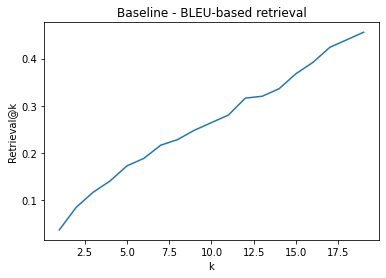

In [42]:
retrieve_at_k(baseline_bleu_scores, expected_retrieved_indices, "Baseline - BLEU-based retrieval")

Retrieval@k: [[0.432]
 [0.544]
 [0.608]
 [0.68 ]
 [0.724]
 [0.752]
 [0.772]
 [0.788]
 [0.804]
 [0.816]
 [0.824]
 [0.836]
 [0.856]
 [0.86 ]
 [0.88 ]
 [0.884]
 [0.884]
 [0.884]
 [0.888]]


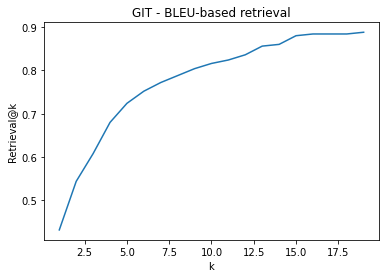

In [43]:
retrieve_at_k(git_bleu_scores, expected_retrieved_indices, "GIT - BLEU-based retrieval")

#### Cosine-similarity-based retrieval

Retrieval@k: [[0.02 ]
 [0.044]
 [0.064]
 [0.088]
 [0.108]
 [0.128]
 [0.16 ]
 [0.196]
 [0.224]
 [0.236]
 [0.26 ]
 [0.296]
 [0.316]
 [0.352]
 [0.356]
 [0.372]
 [0.384]
 [0.396]
 [0.432]]


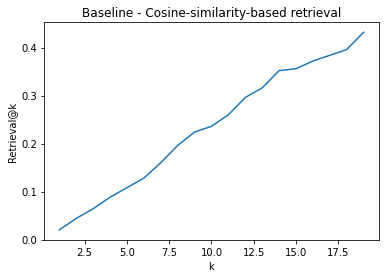

In [44]:
retrieve_at_k(baseline_cosine_scores, expected_retrieved_indices, "Baseline - Cosine-similarity-based retrieval")

Retrieval@k: [[0.216]
 [0.284]
 [0.324]
 [0.376]
 [0.404]
 [0.432]
 [0.456]
 [0.484]
 [0.52 ]
 [0.54 ]
 [0.544]
 [0.556]
 [0.572]
 [0.596]
 [0.612]
 [0.644]
 [0.652]
 [0.664]
 [0.688]]


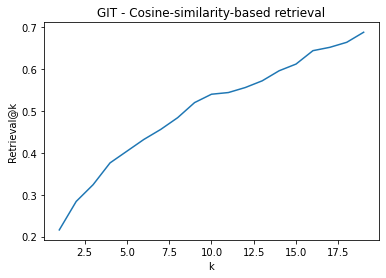

In [45]:
retrieve_at_k(git_cosine_scores, expected_retrieved_indices, "GIT - Cosine-similarity-based retrieval")

#### ROUGE-based retrieval

Retrieval@k: [[0.   ]
 [0.004]
 [0.012]
 [0.016]
 [0.024]
 [0.028]
 [0.028]
 [0.036]
 [0.04 ]
 [0.044]
 [0.052]
 [0.052]
 [0.056]
 [0.056]
 [0.056]
 [0.06 ]
 [0.06 ]
 [0.06 ]
 [0.064]]


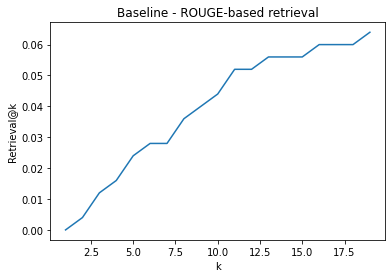

In [58]:
retrieve_at_k(baseline_rouge_scores, expected_retrieved_indices, "Baseline - ROUGE-based retrieval")

Retrieval@k: [[0.   ]
 [0.004]
 [0.012]
 [0.016]
 [0.024]
 [0.028]
 [0.028]
 [0.036]
 [0.04 ]
 [0.044]
 [0.052]
 [0.052]
 [0.056]
 [0.056]
 [0.056]
 [0.06 ]
 [0.06 ]
 [0.06 ]
 [0.064]]


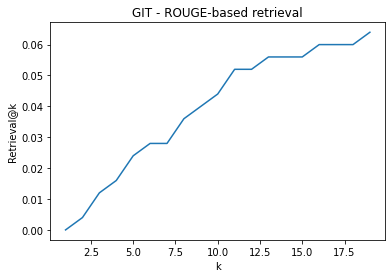

In [59]:
retrieve_at_k(baseline_rouge_scores, expected_retrieved_indices, "GIT - ROUGE-based retrieval")